In [1]:
import sys
sys.path.append('..')
import spark

import jax
import jax.numpy as jnp
import numpy as np
import gymnasium as gym
import ale_py
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt

gym.register_envs(ale_py)

In [ ]:
import jax
import jax.numpy as jnp
from spark.nn.neurons import Neuron, NeuronOutput
from spark.core.payloads import SpikeArray, FloatArray
from spark.core.variables import Constant
from spark.nn.components.somas.leaky import AdaptiveLeakySoma
from spark.nn.components.delays.base import Delays
from spark.nn.components.synapses.base import Synanpses
from spark.nn.components.learning_rules.base import LearningRule
from spark.nn.neurons import ALIFNeuronConfig
from spark.core.specs import InputSpec

class ALIFNeuronRewardConfig(ALIFNeuronConfig):
    pass

class ALIFNeuronReward(Neuron):
    """
        Leaky integrate and fire neuronal model.
    """
    config: ALIFNeuronRewardConfig

    # Auxiliary type hints
    soma: AdaptiveLeakySoma
    delays: Delays
    synapses: Synanpses
    learning_rule: LearningRule

    def __init__(self, config: ALIFNeuronRewardConfig | None = None, **kwargs):
        super().__init__(config=config, **kwargs)
        # Main attributes
        self.inhibitory_rate = self.config.inhibitory_rate
        # Set output shapes earlier to allow cycles.
        self.set_recurrent_shape_contract(shape=self.units)

    def build(self, input_specs: dict[str, InputSpec]):
        # Initialize inhibitory mask.
        inhibitory_units = int(self._units * self.config.inhibitory_rate)
        indices = jax.random.permutation(self.get_rng_keys(1), jnp.arange(self._units), independent=True)[:inhibitory_units]
        inhibition_mask = jnp.ones((self._units,), dtype=self._dtype)
        inhibition_mask = inhibition_mask.at[indices].set(-1).reshape(self.units)
        self._inhibition_mask = Constant(inhibition_mask, dtype=jnp.float16)
        # Soma model.
        self.soma = self.config.soma_config.class_ref(config=self.config.soma_config)
        # Delays model.
        self._delays_active = self.config.learning_rule_config is not None
        if self._delays_active:
            self.delays = self.config.delays_config.class_ref(config=self.config.delays_config)
        # Synaptic model.
        self.synapses = self.config.synapses_config.class_ref(config=self.config.synapses_config)
        # Learning rule model.
        self._learning_active = self.config.learning_rule_config is not None
        if self._learning_active:
            self.learning_rule = self.config.learning_rule_config.class_ref(config=self.config.learning_rule_config)

    def __call__(self, in_spikes: SpikeArray, reward: FloatArray) -> NeuronOutput:
        """
            Update neuron's states and compute spikes.
        """
        # Inference
        if self._delays_active:
            delays_output = self.delays(in_spikes)
            synapses_output = self.synapses(delays_output['out_spikes'])
        else: 
            synapses_output = self.synapses(in_spikes)
        soma_output = self.soma(synapses_output['currents'])
        # Learning
        if self._learning_active:
            learning_rule_output = self.learning_rule(
                reward,
                delays_output['out_spikes'], 
                soma_output['spikes'], 
                self.synapses.get_kernel()
            )
            self.synapses.set_kernel(learning_rule_output['kernel'])
        # Signed spikes
        return {
            'out_spikes': SpikeArray(soma_output['spikes'].spikes, inhibition_mask=self._inhibition_mask)
        }


In [2]:
spiker_specs = spark.ModuleSpecs(
	name ='spiker', 
	module_cls = spark.nn.interfaces.TopologicalLinearSpiker, 
	inputs = {
		'signal': [
			spark.PortMap(origin='__call__', port='drive'),
		]
	},
	config = spark.nn.interfaces.TopologicalLinearSpikerConfig(
		glue = jnp.array(0), 
		mins = jnp.array(-1),  
		maxs = jnp.array(1), 
		resolution = 128, 
		max_freq = 200.0, 
		tau = 30.0
	)
)

ex_config = spark.nn.neurons.ALIFNeuronConfig(
	_s_units = (256,),
	inhibitory_rate = 0.0,
    soma_config = spark.nn.somas.AdaptiveLeakySomaConfig(
        cooldown = 2.0,
	),
    synapses_config = spark.nn.synapses.LinearSynapsesConfig(
        kernel__scale = 15000.0,
        kernel__density = 0.1,
        kernel__max_value = 200.0,
	),
	delays_config = spark.nn.delays.N2NDelaysConfig(
        max_delay = 5.0
	),
    learning_rule_config = spark.nn.learning_rules.ThreeFactorHebbianRuleConfig(
	)
)

in_config = spark.nn.neurons.ALIFNeuronConfig(
	_s_units = (64,),
	inhibitory_rate = 1.0,
    soma_config = spark.nn.somas.AdaptiveLeakySomaConfig(
        cooldown = 1.0,
	),
    synapses_config = spark.nn.synapses.LinearSynapsesConfig(
        kernel__scale = 30000.0,
        kernel__density = 0.1,
        kernel__max_value = 400.0,
	),
	delays_config = spark.nn.delays.N2NDelaysConfig(
        max_delay = 5.0
	),
    learning_rule_config = spark.nn.learning_rules.ThreeFactorHebbianRuleConfig(
	)
)

a_ex_specs = spark.ModuleSpecs(
	name ='A_ex', 
	module_cls = spark.nn.neurons.ALIFNeuron, 
	inputs = {
		'in_spikes': [
			spark.PortMap(origin='spiker', port='spikes'),
			spark.PortMap(origin='A_ex', port='out_spikes'),
			spark.PortMap(origin='B_in', port='out_spikes'),
		],
        'reward': [
            spark.PortMap(origin='__call__', port='reward'),
		]
	},
	config = ex_config
)

a_in_specs = spark.ModuleSpecs(
	name ='A_in', 
	module_cls = spark.nn.neurons.ALIFNeuron, 
	inputs = {
		'in_spikes': [
			spark.PortMap(origin='spiker', port='spikes'),
			spark.PortMap(origin='A_ex', port='out_spikes'),
		],
        'reward': [
            spark.PortMap(origin='__call__', port='reward'),
		]
	},
	config = in_config
)

b_ex_specs = spark.ModuleSpecs(
	name ='B_ex', 
	module_cls = spark.nn.neurons.ALIFNeuron, 
	inputs = {
		'in_spikes': [
			spark.PortMap(origin='spiker', port='spikes'),
			spark.PortMap(origin='B_ex', port='out_spikes'),
			spark.PortMap(origin='A_in', port='out_spikes'),
		],
        'reward': [
            spark.PortMap(origin='__call__', port='reward'),
		]
	},
	config = ex_config
)

b_in_specs = spark.ModuleSpecs(
	name ='B_in', 
	module_cls = spark.nn.neurons.ALIFNeuron, 
	inputs = {
		'in_spikes': [
			spark.PortMap(origin='spiker', port='spikes'),
			spark.PortMap(origin='B_ex', port='out_spikes'),
		],
        'reward': [
            spark.PortMap(origin='__call__', port='reward'),
		]
	},
	config = in_config
)

integrator = spark.ModuleSpecs(
	name ='integrator', 
	module_cls = spark.nn.interfaces.ExponentialIntegrator, 
	inputs = {
		'spikes': [
			spark.PortMap(origin='A_ex', port='out_spikes'),
			spark.PortMap(origin='B_ex', port='out_spikes'),
		]
	},
	config = spark.nn.interfaces.ExponentialIntegratorConfig(
		num_outputs = 2,
	)
)
input_map = {
    'drive': spark.InputSpec(
        payload_type=spark.FloatArray, 
        shape=(4,), 
        dtype=jnp.float16,
	),
    'reward': spark.InputSpec(
        payload_type=spark.FloatArray, 
        shape=(1,), 
        dtype=jnp.float16,
	)
}
output_map = {
	'action': {
		'input': spark.PortMap(
			origin='integrator',
			port='signal'
		),
		'spec': spark.OutputSpec(
			payload_type=spark.FloatArray,
			shape=(2,),
			dtype=jnp.float16
		)
	}
}
        
modules_map = {
    'spiker': spiker_specs,
    'A_ex': a_ex_specs,
    'A_in': a_in_specs,
	'B_ex': b_ex_specs,
	'B_in': b_in_specs,
	'integrator': integrator,
}

brain_config = spark.nn.BrainConfig(input_map=input_map, output_map=output_map, modules_map=modules_map)
brain_config.to_file('example_ab_model.scfg')

Successfully exported data to example_ab_model.scfg


In [3]:
# Utility function to execute brain efficiently.
@partial(jax.jit, static_argnames='steps')
def run_model(graph, state, steps, **inputs):
	# Merge model
	model = spark.merge(graph, state)
	# Run model
	for _ in range(steps):
		out = model(**inputs)
	# Get new state
	_, state = spark.split((model))
	return out, state

# Utility function to retrieve data from the model.
@partial(jax.jit, static_argnames='steps')
def run_model_and_record(graph, state, steps, **inputs):
	# Merge model
	model = spark.merge(graph, state)
	# Prepare spike container
	spikes = {k: [] for k in model.get_spikes_from_cache().keys()}
	for _ in range(steps):
		# Run model
		out = model(**inputs)
		# Get spikes
		for k, v in model.get_spikes_from_cache().items():
			spikes[k].append(v)
	# Get new state
	_, state = spark.split((model))
	# Process spikes
	process_spikes = []
	for s in range(steps):
		process_spikes.append(
			jnp.concatenate([spikes[k][s].value.reshape(-1) for k in spikes.keys()])
		)
	return out, state, process_spikes

# Utility function to preprocess information from the environment.
def process_obs(x):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	x = x / np.array([2.4, 2.5, 0.2095, 3.5])
	x = np.clip(x, a_min=-1, a_max=1)
	return x

# Reward function.
def compute_real_reward(x, x_prev, r_prev, terminated):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	if terminated:
		return 0
	r = (x_prev[0]**2 - x[0]**2) + (x_prev[2]**2 - x[2]**2)
	r = np.clip(0.5 * r_prev + 2 * r, a_min=-1, a_max=1)
	return r

In [4]:
env_name =  'CartPole-v1'
env = gym.make(env_name, sutton_barto_reward=True)
next_obs, _ = env.reset(seed=42)
next_obs = process_obs(next_obs)

STEPS_10MS = 10
TRAIN_EPOCHES = 100
TEST_EPOCHES = 10

100%|██████████| 100/100 [00:00<00:00, 9509.60it/s]

Random performed an average of 21.49 actions per episode!


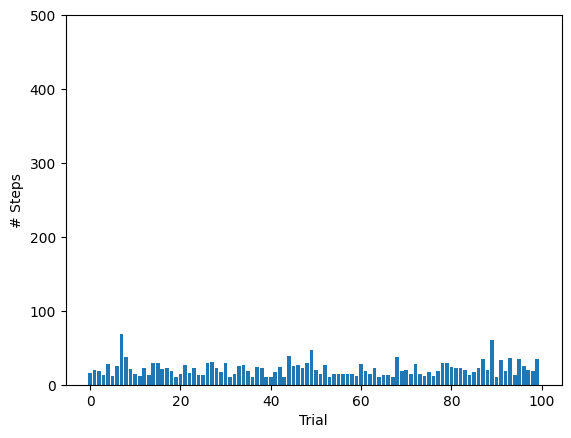

In [5]:
# A fresh environment
next_obs, _ = env.reset(seed=42)
# Some classic training loop.
random_steps = []
for i in tqdm(range(TRAIN_EPOCHES)):
	terminated = False
	tmp_step = 0
	while not terminated:
		# Environment logic.
		next_action = int(np.random.rand() < 0.5)
		next_obs, reward, terminated, truncated, info = env.step(next_action)
		#reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
		tmp_step += 1
	random_steps.append(tmp_step)
	# Reset environment
	next_obs, _ = env.reset()

print(f'Random performed an average of {np.mean(random_steps)} actions per episode!')
plt.bar(np.arange(len(random_steps)), random_steps)
plt.xlabel('Trial')
plt.ylabel('# Steps')
plt.ylim(0, 500)
plt.show()

In [6]:
# Load the Brain.
brain_config = spark.nn.BrainConfig.from_file('example_ab_model.scfg')
# Initialize the Brain.
brain = spark.nn.Brain(config=brain_config)
# Build the Brain.
brain(
    drive=spark.FloatArray(jnp.zeros((4,), dtype=jnp.float16)), 
    reward=spark.FloatArray(jnp.zeros((1,), dtype=jnp.float16))
)
# Split brain into the graph and the state
graph, state = spark.split((brain))
# Compitle runtime fn. Depending on the number of steps this may take a little bit of time.
run_model(
    graph, state, steps=STEPS_10MS, 
	drive=spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
    reward=spark.FloatArray(jnp.zeros((1,), dtype=jnp.float16))
)
run_model_and_record(
    graph, state, steps=STEPS_10MS, 
    drive=spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
    reward=spark.FloatArray(jnp.zeros((1,), dtype=jnp.float16))
);

In [20]:
brain.A_ex._inhibition_mask.value * jnp.zeros(brain.A_ex._inhibition_mask.value.shape)

brain.A_in._inhibition_mask.value * jnp.zeros(brain.A_in._inhibition_mask.value.shape, dtype=jnp.float16)

Array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],      dtype=float16)

100%|██████████| 100/100 [00:02<00:00, 36.63it/s]

Brain performed a total of 2478 actions!
Brain performed an average of 23.39 actions per episode!
Brain performed an average of 22.2 actions during the last 10 episodes!


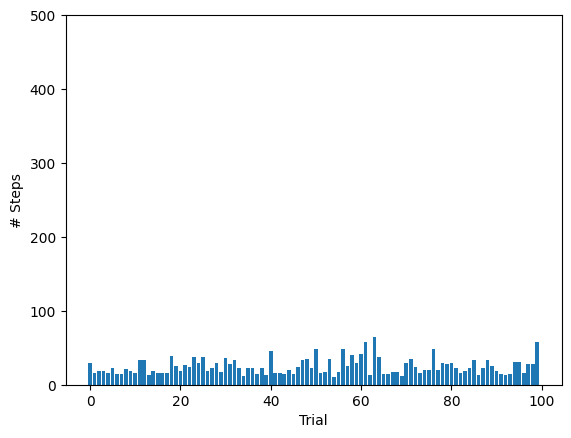

In [16]:
# A fresh brain (It is a good idea to keep the original initial state to avoid recompialtions)
#_, state = spark.split((brain))
# A fresh environment
next_obs, _ = env.reset(seed=42)
reward = 0
# Some classic training loop.
steps = []
for i in tqdm(range(TRAIN_EPOCHES)):
	terminated = False
	tmp_step = 0
	while not terminated:
		next_obs = process_obs(next_obs)
		prev_obs = next_obs
		# Model logic
		out, state = run_model(
			graph, state, steps=STEPS_10MS, 
			drive=spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
    		reward=spark.FloatArray(jnp.array(reward, dtype=jnp.float16))
		)
		# Environment logic.
		next_action = int(np.argmax(out['action'].value))
		next_obs, reward, terminated, truncated, info = env.step(next_action)
		#reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
		tmp_step += 1
	steps.append(tmp_step)

	# One extra step with the reward
	for _ in range(1):
		_, state = run_model(
			graph, state, steps=STEPS_10MS, 
			drive=spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
			reward=spark.FloatArray(jnp.array(reward, dtype=jnp.float16))
		)

	# Reset environment
	next_obs, _ = env.reset()
	reward = 0
	if False:
		# Flush model. Pass a zero vector for 10 ms to let the model "cooldown" a little bit.
		for _ in range(3):
			_, state = run_model(
				graph, state, steps=STEPS_10MS, 
				drive=spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)),
				reward=spark.FloatArray(jnp.array(reward, dtype=jnp.float16))
			)

print(f'Brain performed a total of {sum(steps)} actions!')
print(f'Brain performed an average of {np.mean(random_steps)} actions per episode!')
print(f'Brain performed an average of {np.mean(random_steps[-10:])} actions during the last 10 episodes!')
plt.bar(np.arange(len(steps)), steps)
plt.xlabel('Trial')
plt.ylabel('# Steps')
plt.ylim(0, 500)
plt.show()

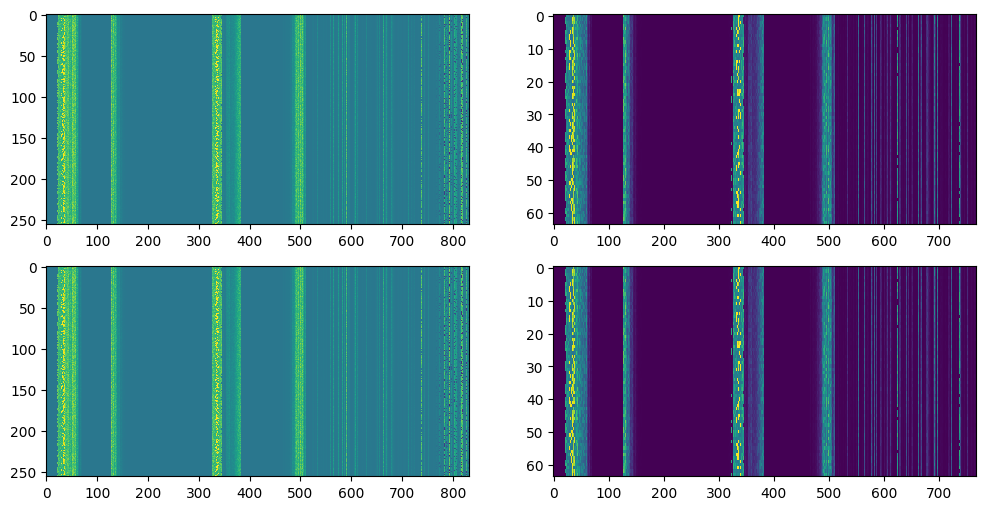

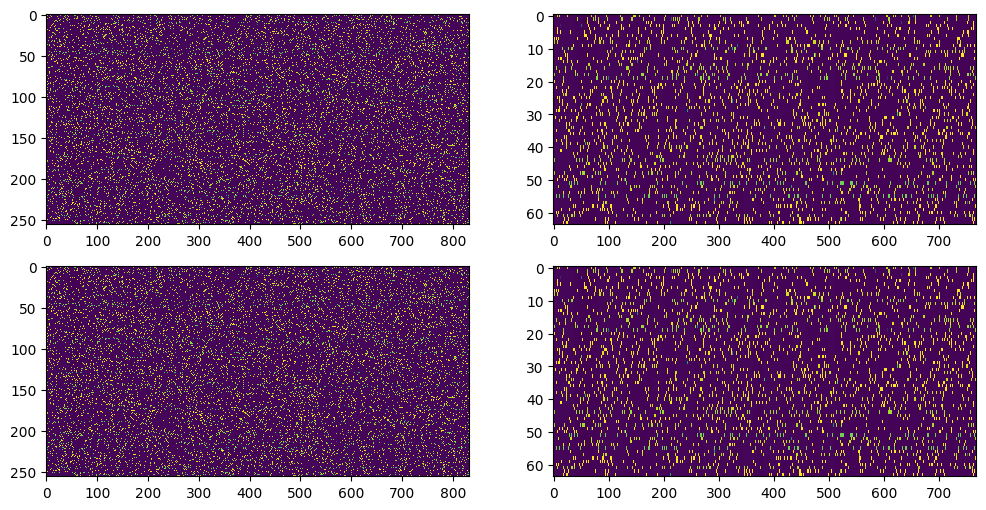

In [17]:
model = spark.merge(graph, state)

fig, ax = plt.subplots(2,2, figsize=(12,6))
ax[0,0].imshow(model.A_ex.learning_rule.pre_trace.value, aspect='auto', interpolation='none')
ax[0,1].imshow(model.A_in.learning_rule.pre_trace.value, aspect='auto', interpolation='none')
ax[1,0].imshow(model.B_ex.learning_rule.pre_trace.value, aspect='auto', interpolation='none')
ax[1,1].imshow(model.B_in.learning_rule.pre_trace.value, aspect='auto', interpolation='none')
plt.show()

fig, ax = plt.subplots(2,2, figsize=(12,6))
ax[0,0].imshow(model.A_ex.synapses.kernel.value, aspect='auto', interpolation='none')
ax[0,1].imshow(model.A_in.synapses.kernel.value, aspect='auto', interpolation='none')
ax[1,0].imshow(model.B_ex.synapses.kernel.value, aspect='auto', interpolation='none')
ax[1,1].imshow(model.B_in.synapses.kernel.value, aspect='auto', interpolation='none')
plt.show()

In [19]:
jax.Array[jnp.bool]

TypeError: type 'jaxlib._jax.Array' is not subscriptable

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


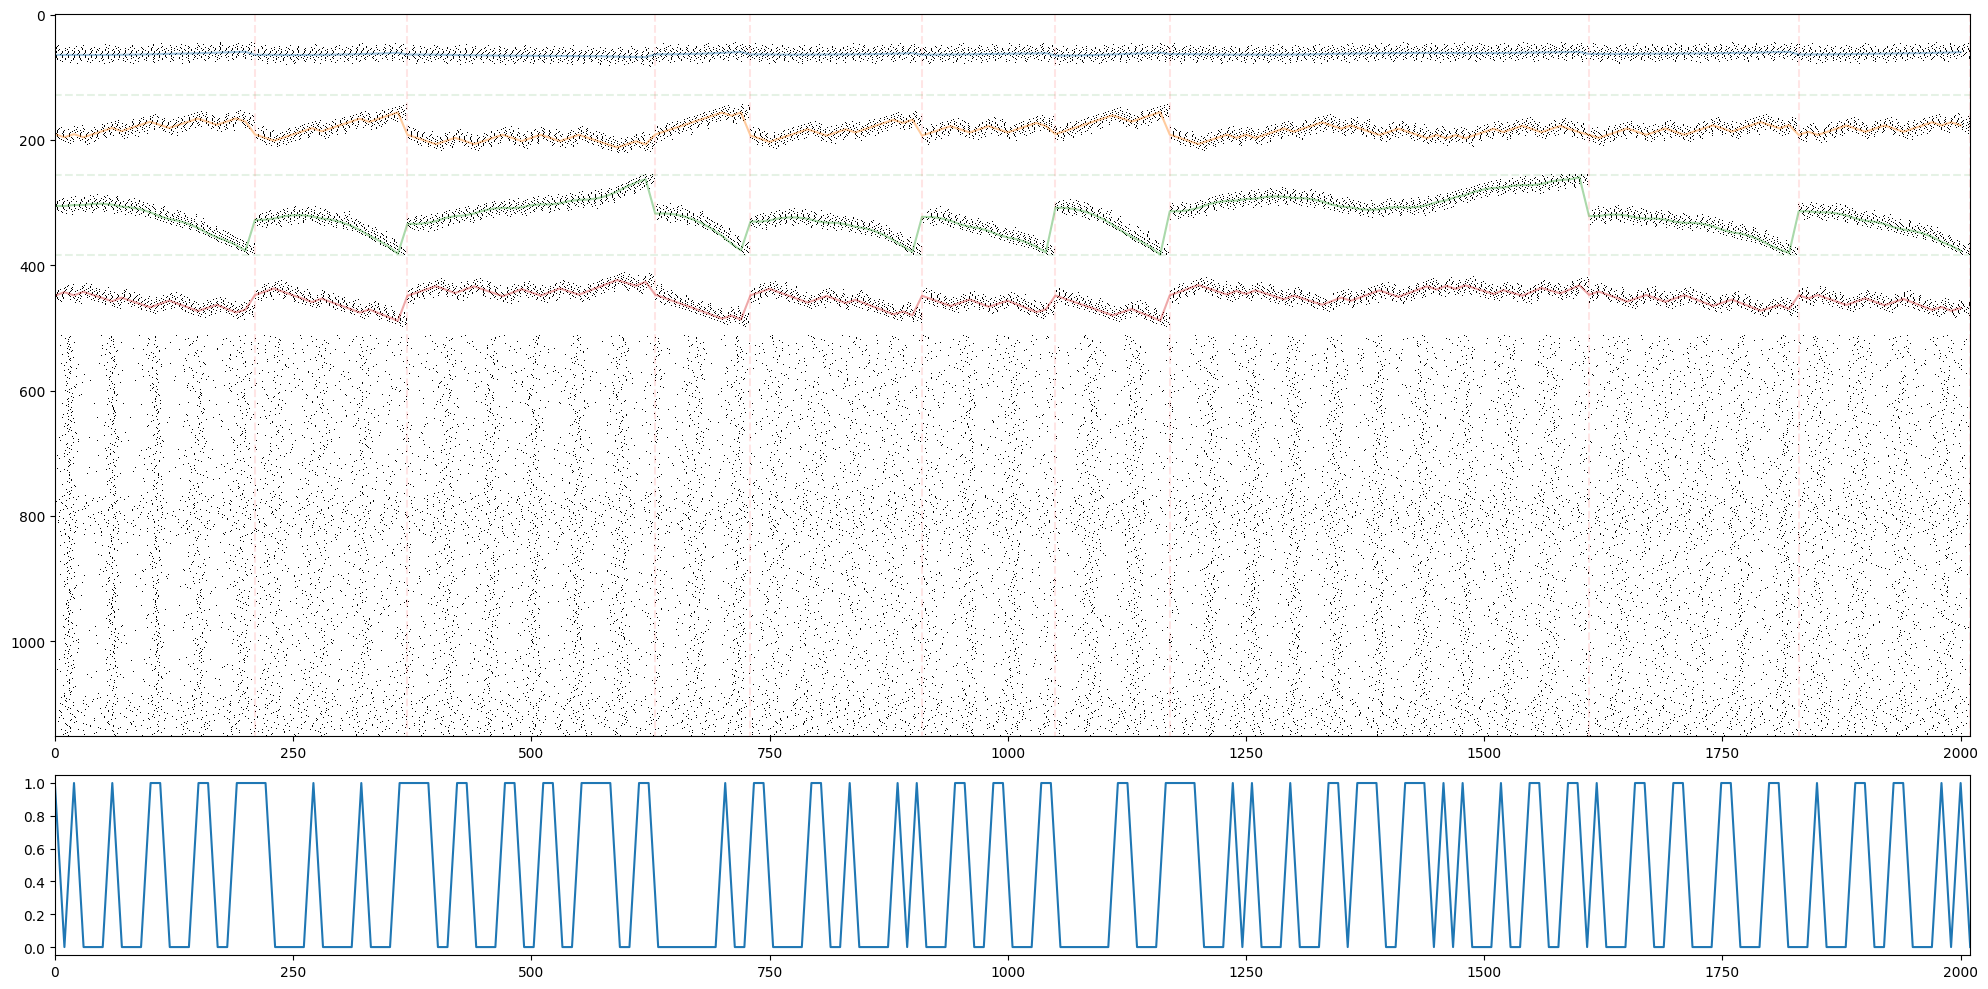

In [18]:
spikes = []
breaks = []
actions = []
env_obs = []
reward = 0
# A fresh environment
next_obs, _ = env.reset(seed=42+1)
env_steps = 0
for i in tqdm(range(TEST_EPOCHES)):
	terminated = False
	while not terminated:
		next_obs = process_obs(next_obs)
		env_obs.append(next_obs)
		prev_obs = next_obs
		# Model logic
		out, state, model_spikes = run_model_and_record(
			graph, state, steps=STEPS_10MS, 
			drive=spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)),
    		reward=spark.FloatArray(jnp.array(0, dtype=jnp.float16))
		)
		spikes += model_spikes
		# Environment logic.
		next_action = int(np.argmax(out['action'].value))
		next_obs, _, terminated, truncated, info = env.step(next_action)
		reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
		actions.append(next_action)
		env_steps += 1
	# Reset environment
	next_obs, _ = env.reset()
	breaks.append(STEPS_10MS*env_steps)
	# Flush model. Pass a zero vector for 10 ms to let the model "cooldown" a little bit.
	for _ in range(10):
		_, state = run_model(
			graph, state, steps=STEPS_10MS, 
			drive=spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)),
    		reward=spark.FloatArray(jnp.array(0, dtype=jnp.float16))
		)
	
model = spark.merge(graph, state)
spikes = np.abs(np.array(spikes))

fig, ax = plt.subplots(2,1,figsize=(20,10), height_ratios=(8,2))
ax[0].imshow(1-spikes.T, cmap='gray', aspect='auto', interpolation='none')
for b in breaks:
    ax[0].plot([b,b], [0-0.5,spikes.shape[1]-0.5], 'r--', alpha=0.1)
for i in range(3):
    ax[0].plot([0-0.5,len(spikes)-0.5], [128*(i+1), 128*(i+1)], 'g--', alpha=0.1)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[0]+64, alpha=0.4)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[1]+64+128, alpha=0.4)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[2]+64+256, alpha=0.4)
ax[0].plot(STEPS_10MS*np.arange(len(spikes)//STEPS_10MS), 64*np.array(env_obs).T[3]+64+128+256, alpha=0.4)
ax[1].plot(np.linspace(0,breaks[-1], len(actions)), actions)
ax[0].set_xlim(0, breaks[-1])
ax[1].set_xlim(0, breaks[-1])
plt.tight_layout()
plt.show()